<a href="https://colab.research.google.com/github/hansa31/GBM-analysis/blob/main/Models_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.0 MB/s eta 0:00:00


In [3]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#import xgboost as xgb

import shap

shap.initjs()

In [4]:
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree

from sklearn.model_selection import StratifiedKFold

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

#import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GBM/PreProcess_data_with_Survival_days.csv')
df.head()

,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,...,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1,Age,Survival,Survival_cat
0,1662,384,36268,2046,38314,1469432,4.328125,0.045826,0.010588,0.81232,...,61.3293,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.0000,56.208219,558,HIGH
1,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.50075,...,3.5999,3.31250,1.000000e-09,0.077619,0.122900,0.094336,91.4736,61.526027,322,MID
2,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.061444,0.40729,...,0.8048,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.4290,18.975342,630,HIGH
3,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,0.61489,...,4.7336,3.87500,1.000000e-09,0.100415,0.088249,0.096470,128.4680,33.887671,370,MID
4,34538,7137,65653,41675,107328,1365237,4.839288,0.526069,0.108708,0.82875,...,2.4532,1.00000,5.730000e-08,0.106184,0.131952,0.096894,240.7780,54.986301,86,LOW


In the above df the Survival_cat is calculated as follows,

300,450

In [6]:
from sklearn.preprocessing import StandardScaler

# take x data and y data from the df_noAge, and convert them to numpy arrays, y is the last column which is catogorical
X = df.iloc[:, :-2].values
y = df.iloc[:, -2].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(76, 705)

In [7]:
y_labels = df.iloc[:,-1].values

In [8]:
y_labels

array(['HIGH', 'MID', 'HIGH', 'MID', 'LOW', 'MID', 'LOW', 'LOW', 'MID',
       'LOW', 'LOW', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'LOW', 'HIGH', 'MID',
       'HIGH', 'LOW', 'LOW', 'MID', 'HIGH', 'HIGH', 'MID', 'LOW', 'LOW',
       'LOW', 'MID', 'MID', 'LOW', 'HIGH', 'LOW', 'HIGH', 'LOW', 'HIGH',
       'MID', 'MID', 'HIGH', 'LOW', 'MID', 'HIGH', 'HIGH', 'LOW', 'HIGH',
       'LOW', 'HIGH', 'MID', 'LOW', 'MID', 'HIGH', 'MID', 'HIGH', 'MID',
       'LOW', 'HIGH', 'MID', 'LOW', 'HIGH', 'MID', 'LOW', 'LOW', 'MID',
       'LOW', 'LOW', 'LOW', 'LOW', 'HIGH', 'LOW', 'HIGH', 'LOW', 'MID',
       'HIGH', 'LOW', 'LOW', 'LOW'], dtype=object)

In [9]:
y

array([ 558,  322,  630,  370,   86,  430,  110,  209,  448,  199,  291,
        600,  804,  634, 1561,  268,  822,  355, 1489,   82,  187,  394,
        812,  737,  362,   67,   71,  262,  424,  329,  104, 1731,  127,
        616,  111,  828,  317,  405,  621,  175,  357,  747,  946,  103,
        468,   82,  467,  425,   22,  382, 1282,  327,  635,  448,  296,
        626,  372,  121,  476,  333,   30,  232,  434,   99,    5,  213,
        244, 1458,   77,  508,   82,  346,  519,  254,  147,  153])

Results from the previous RFE

Selected 5 features: Index(['HISTO_NET_T2_Bin9', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'Age'], dtype='object')

Selected 6 features: Index(['HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'Age'], dtype='object')

Selected 7 features: Index(['HISTO_NET_T2_Bin9', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 8 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'Age'], dtype='object')

Selected 9 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LZLGE', 'TEXTURE_GLSZM_NET_T2_LGZE', 'Age'], dtype='object')

Selected 10 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 11 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 12 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T2_ZP', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 13 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_SZLGE', 'TEXTURE_GLSZM_NET_T1_SZHGE', 'TEXTURE_GLSZM_NET_T1_LZLGE', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 14 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T2_SZE', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_GLN', 'TEXTURE_GLSZM_NET_T2_ZP', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TEXTURE_GLSZM_NET_T2_ZSV', 'TGM_T_1', 'Age'], dtype='object')

Selected 15 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin6', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_SZHGE', 'TEXTURE_GLSZM_NET_T1_LZLGE', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 16 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_GLN', 'TEXTURE_GLSZM_NET_T2_ZSN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 17 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_NET_T1_Bin10', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 18 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin8', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_SZE', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TEXTURE_GLSZM_NET_FLAIR_GLV', 'TGM_T_1', 'Age'], dtype='object')

Selected 19 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin5', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T2_SZE', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_GLN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TEXTURE_NGTDM_ET_T1Gd_Strength', 'TGM_T_1', 'Age'], dtype='object')

Selected 20 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin10', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LGZE', 'TEXTURE_GLSZM_NET_T1_HGZE', 'TEXTURE_GLSZM_NET_T1_SZLGE', 'TEXTURE_GLSZM_NET_T1_SZHGE', 'TEXTURE_GLSZM_NET_T1_LZLGE', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 21 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin9', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin5', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_SZE', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_GLN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 22 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin8', 'HISTO_NET_T1Gd_Bin9', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_SZE', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_GLN', 'TEXTURE_GLSZM_NET_T2_ZSN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TEXTURE_NGTDM_ET_T2_Coarseness', 'TGM_T_1', 'Age'], dtype='object')

Selected 23 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin8', 'HISTO_NET_T1Gd_Bin9', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin6', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_SZHGE', 'TEXTURE_GLSZM_NET_T1_LZLGE', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 24 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin8', 'HISTO_NET_T1Gd_Bin9', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin5', 'HISTO_ET_T1_Bin6', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_SZE', 'TEXTURE_GLSZM_NET_T2_LZE', 'TEXTURE_GLSZM_NET_T2_ZSN', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

Selected 25 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T1Gd_Bin8', 'HISTO_NET_T1Gd_Bin9', 'HISTO_NET_T1Gd_Bin10', 'HISTO_ET_T1_Bin1', 'HISTO_ET_T1_Bin2', 'HISTO_ET_T1_Bin3', 'HISTO_ET_T1_Bin4', 'HISTO_ET_T1_Bin5', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_LGZE', 'TEXTURE_GLSZM_NET_T1_HGZE', 'TEXTURE_GLSZM_NET_T1_SZLGE', 'TEXTURE_GLSZM_NET_T1_SZHGE', 'TEXTURE_GLSZM_NET_T1_LZLGE', 'TEXTURE_GLSZM_NET_T1_LZHGE', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T1_ZSV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'], dtype='object')

# Selecting Columns

In [10]:
# Extract corresponding values using NumPy indexing
valid_columns = ['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age']
selected_values = X_scaled[:, [df.columns.get_loc(col) for col in valid_columns]]

# CART

In [11]:
# helper function

def fitting(X_train,X_test,y_train, y_test, criterion, splitter, mdepth,
            minleaf, min_samples_split, feature_names):

    # Create training and testing samples
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Fit the model
    model = tree.DecisionTreeRegressor(criterion=criterion,
                             splitter=splitter,
                             max_depth=mdepth,
                             min_samples_leaf=minleaf,
                             min_samples_split=min_samples_split,
                             random_state=0)

    clf = model.fit(X_train, y_train)

    # Predict on test and training data
    pred_values_te = model.predict(X_test)
    pred_values_tr = model.predict(X_train)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    #print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")

    # Calculate MSE and R-squared for test data
    mse_te = mean_squared_error(y_test, pred_values_te)
    r2_te = r2_score(y_test, pred_values_te)

    # Calculate MSE and R-squared for training data
    mse_tr = mean_squared_error(y_train, pred_values_tr)
    r2_tr = r2_score(y_train, pred_values_tr)

    print('*************** Evaluation on Test Data ***************')
    print('Mean Squared Error: ', mse_te)
    print('R-squared: ', r2_te)
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Training Data ***************')
    print('Mean Squared Error: ', mse_tr)
    print('R-squared: ', r2_tr)
    print('--------------------------------------------------------')
    print("")

    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_names,
                                #class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1], str(list(clf.classes_)[2]))],
                                #class_names = ['HIGH', 'LOW', 'MID'],
                                filled=True,
                                rounded=True,
                                #rotate=True,
                               )
    graph = graphviz.Source(dot_data)

    # Return relevant data for chart plotting
    #return X_train, X_test, y_train, y_test, clf, graph
    return clf, graph

In [12]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Create stratified KFold object
skf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric (e.g., mean squared error for regression)
scorer = 'neg_mean_squared_error'  # Use 'neg_' for minimization

# Create and train the GridSearchCV model
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=skf, scoring=scorer)
grid_search.fit(selected_values, y)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model for prediction and classification
y_pred = best_model.predict(selected_values)
y_pred_labels = np.where(y_pred < 300, "LOW", np.where(y_pred >= 450, "HIGH", "MID"))


In [13]:
score = accuracy_score(y_pred_labels, y_labels)
score

0.7236842105263158

In [14]:
best_params

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

FOLD 0 ******************************************
*************** Tree Summary ***************
Tree Depth:  4
No. of leaves:  10
No. of features:  10
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Mean Squared Error:  45047.89737654321
R-squared:  0.1966525351407734
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Mean Squared Error:  36134.17530929039
R-squared:  0.7427553495086467
--------------------------------------------------------

FOLD 1 ******************************************
*************** Tree Summary ***************
Tree Depth:  5
No. of leaves:  11
No. of features:  10
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Mean Squared Error:  468584.48960069445
R-squared:  -0.9432385163086838
--------------------------------------------------------

*************** Evaluation

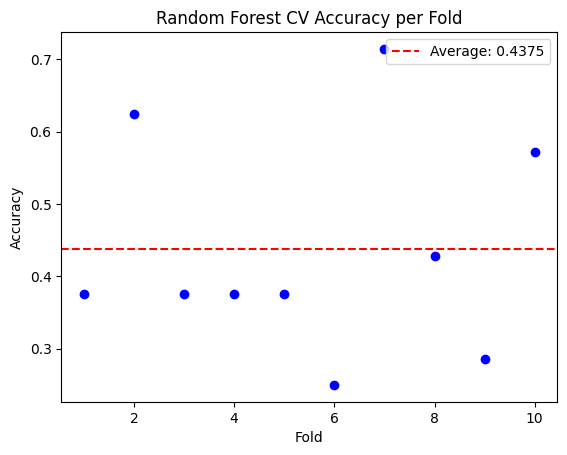

Average cross-validation accuracy: 0.4375


In [15]:
# Define number of folds for cross-validation
n_folds = 10

# Stratified K-Fold cross-validation
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize empty lists to store scores and predictions
scores = []
y_pred = np.zeros_like(y)

# convert the predictions to labels and store them
y_pred_labels = []

# temp list
temp = []

# Empty list to hold the graph objects
graph_list = []

# Empty list to hold the models
models_list = []

# Plot setup
fig, ax = plt.subplots()

# Iterate over folds
for fold_id, (train_index, test_index) in enumerate(skf.split(selected_values, y)):

    print(f"FOLD {fold_id} ******************************************")
    # Split data into training and testing sets
    X_train, X_test = selected_values[train_index], selected_values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # for the labeled test set
    y_train_labels, y_test_labels = y_labels[train_index], y_labels[test_index]

    # Create and train the Random Forest model
    #model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed
    #model.fit(X_train, y_train)

    # Create the Decision tree model
    model, graph = fitting(X_train, X_test, y_train, y_test, "squared_error", 'best',
                                                       mdepth=5,
                                                       minleaf=5,
                                                       min_samples_split = 2,
                                                       feature_names = valid_columns)

    graph_list.append(graph)
    models_list.append(model)

    # Make predictions on the test set
    y_pred[test_index] = model.predict(X_test)

    # regression to classification
    low_threshold = 300
    high_threshold = 450

    #print(y_pred[test_index][0])


    # Classify predictions based on thresholds
    #y_pred_labels[test_index] = np.where(y_pred[test_index] < low_threshold, "LOW", np.where(y_pred[test_index] >= high_threshold, "HIGH", "MID"))
    temp = np.where(y_pred[test_index] < low_threshold, "LOW", np.where(y_pred[test_index] >= high_threshold, "HIGH", "MID"))

    # Evaluate the model using accuracy (replace with your desired metric)
    #from sklearn.metrics import accuracy_score
    #score = accuracy_score(y_test_labels, y_pred_labels[test_index])
    score = accuracy_score(y_test_labels, temp)
    scores.append(score)

    # Plot individual fold accuracy
    ax.plot([fold_id + 1], [score], marker='o', linestyle='-', color='b')

# Plot average accuracy line
avg_score = np.mean(scores)
ax.axhline(y=avg_score, color='r', linestyle='--', label=f'Average: {avg_score:.4f}')

# Customize plot
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest CV Accuracy per Fold')
ax.legend()
plt.show()

# Print the average cross-validation score
print(f"Average cross-validation accuracy: {np.mean(scores):.4f}")

Get the 7th model for SHAP analysis

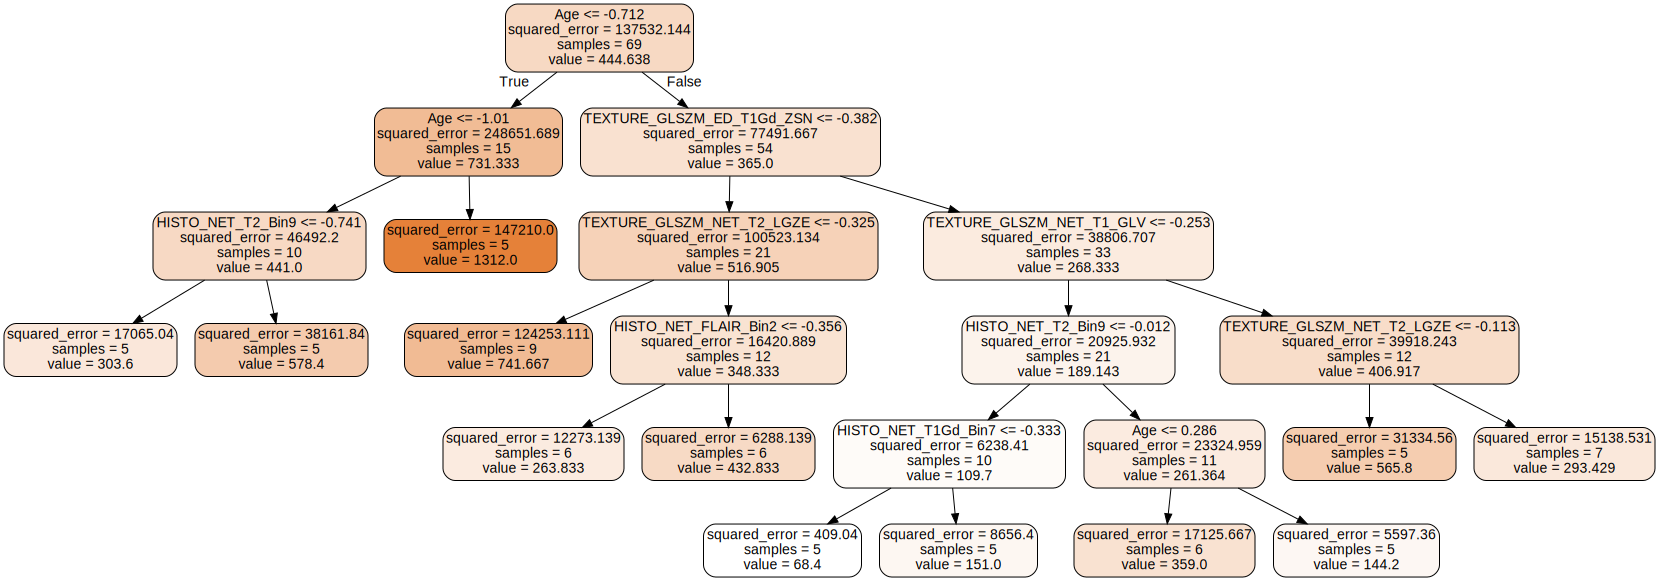

In [16]:
graph_list[6]

### Trying to plot CV losses

In [32]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Create stratified KFold object
skf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric (e.g., mean squared error for regression)
scorer = 'neg_mean_squared_error'  # Use 'neg_' for minimization

# Create storage for CV losses
cv_losses = []

def plot_cv_losses(cv_results, grid_param_1, grid_param_2, label):
  # Extract fold losses
  fold_losses = cv_results['mean_test_score']

  # Calculate mean and standard deviation of fold losses
  mean_loss = np.mean(fold_losses)
  std_dev = np.std(fold_losses)

  # Plot losses with error bars
  plt.plot([grid_param_1], [mean_loss], marker='o', linestyle='-', label=label)
  plt.errorbar([grid_param_1], [mean_loss], yerr=std_dev, fmt='none', ecolor='b', capsize=7)

# Create and train the GridSearchCV model with loss plotting
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=skf, scoring=scorer)
grid_search.fit(selected_values, y)

# Get the best model and parameters (updated way)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Convert dict_values to a list for slicing
param_grid_values_list = list(grid_search.param_grid.values())

# Extract and plot CV losses for each parameter combination
cv_results = grid_search.cv_results_
print(cv_results)

for param_1, param_2, cv_result in zip(grid_search.param_grid.keys(),
                                       param_grid_values_list[1:],
                                       cv_results['mean_test_score']):
  plot_cv_losses(cv_result, param_1, param_2, f"{param_1},{param_2}")

# Finalize plot
plt.xlabel(list(grid_search.param_grid.keys())[0])  # Label based on first param
plt.ylabel('Mean Squared Error (Lower is better)')
plt.title('GridSearchCV - Mean Squared Error per Parameter Combination')
plt.legend()
plt.grid(True)
plt.show()

{'mean_fit_time': array([0.00069141, 0.00054085, 0.00055654, 0.00053749, 0.00054071,
       0.0005686 , 0.00071421, 0.00056896, 0.00053439, 0.00070136,
       0.00061636, 0.00064037, 0.00062823, 0.0006119 , 0.00060625,
       0.00056722, 0.00057888, 0.0005656 , 0.00073035, 0.0007055 ,
       0.00079229, 0.00062742, 0.00065324, 0.00064771, 0.00062022,
       0.00060561, 0.00057986]), 'std_fit_time': array([2.15293614e-04, 8.49001162e-06, 3.50081050e-05, 1.10360764e-05,
       1.92563264e-05, 5.16950036e-05, 1.56086662e-04, 8.62030192e-05,
       1.08107513e-05, 8.07282668e-05, 8.04414534e-06, 4.29232180e-05,
       4.67155638e-05, 1.83055947e-05, 4.67658879e-05, 7.93719048e-06,
       2.01022353e-05, 1.26766286e-05, 6.68014695e-05, 7.70255454e-05,
       2.38242166e-04, 2.17591930e-05, 6.71857845e-05, 9.36891009e-05,
       7.49093723e-05, 6.01592441e-05, 1.98960126e-05]), 'mean_score_time': array([0.00037246, 0.00029805, 0.00030122, 0.00030169, 0.00030062,
       0.00034804, 0.00045109

IndexError: invalid index to scalar variable.

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Create stratified KFold object
skf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric (e.g., mean squared error for regression)
scorer = 'neg_mean_squared_error'  # Use 'neg_' for minimization

# Create storage for CV losses
cv_losses = []

def plot_cv_losses(cv_results, grid_param_1, grid_param_2, label):
  # Extract fold losses
  fold_losses = cv_results['mean_test_score']

  # Calculate mean and standard deviation of fold losses
  mean_loss = np.mean(fold_losses)
  std_dev = np.std(fold_losses)

  # Plot losses with error bars
  plt.plot([grid_param_1], [mean_loss], marker='o', linestyle='-', label=label)
  plt.errorbar([grid_param_1], [mean_loss], yerr=std_dev, fmt='none', ecolor='b', capsize=7)

# Create and train the GridSearchCV model with loss plotting
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=skf, scoring=scorer)
grid_search.fit(X, y)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Extract and plot CV losses for each parameter combination
cv_results = grid_search.cv_results_
for param_1, param_2, cv_result in zip(grid_search.param_grid[grid_search.best_params_index_],
                                       grid_search.param_grid.values()[1:],
                                       cv_results['cv_results']):
  plot_cv_losses(cv_result, param_1, param_2, f"{param_1},{param_2}")

# Finalize plot
plt.xlabel(list(grid_search.param_grid.keys())[0])  # Label based on first param
plt.ylabel('Mean Squared Error (Lower is better)')
plt.title('GridSearchCV - Mean Squared Error per Parameter Combination')
plt.legend()
plt.grid(True)
plt.show()

# Use the best model for prediction and classification
#y_pred = best_model.predict(X)
#y_pred_labels = np.where(y_pred < 300, "LOW", np.where(y_pred >= 450, "HIGH", "MID"))

# Evaluate the model performance on unseen data (optional)
#from sklearn.metrics import r2_score

#accuracy = r2_score(y, y_pred)  # Use R-squared for regression accuracy
#print(f"Final Model R-squared (Accuracy): {accuracy:.4f}")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_index_'

# SHAP ANALYSIS - Decision Tree (10 Features)

In [17]:
model_shap = models_list[6]
#Get shap values
explainer = shap.Explainer(model_shap,feature_names=valid_columns)
shap_values= explainer(selected_values)

print(np.shape(shap_values))

(76, 10)


## Individual Waterfall plots & Force plots

Can be used to determine how the model reacts to out of the context samples

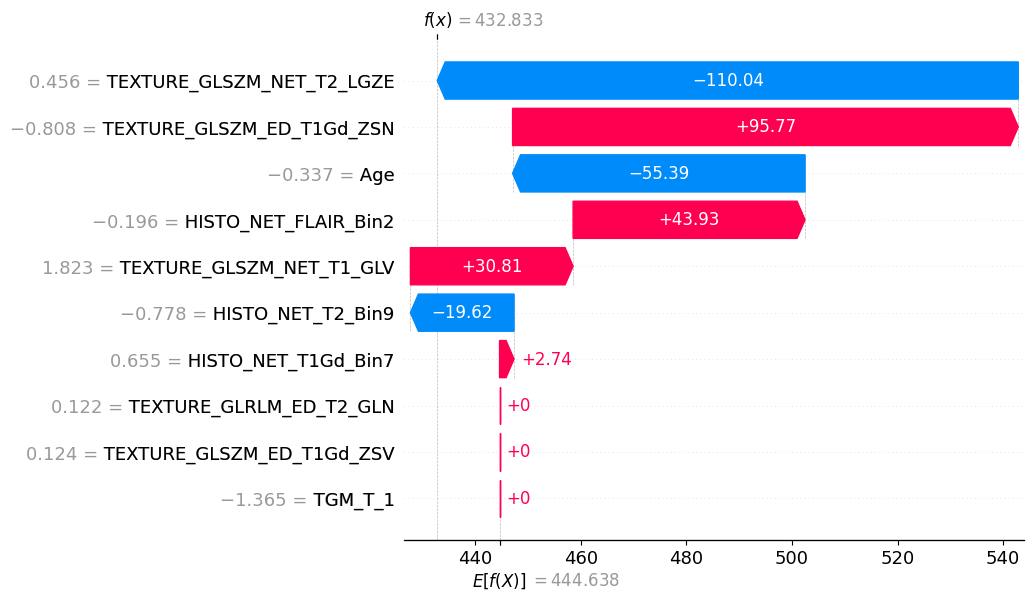

In [18]:
shap.plots.waterfall(shap_values[0])

In [19]:
shap.initjs()

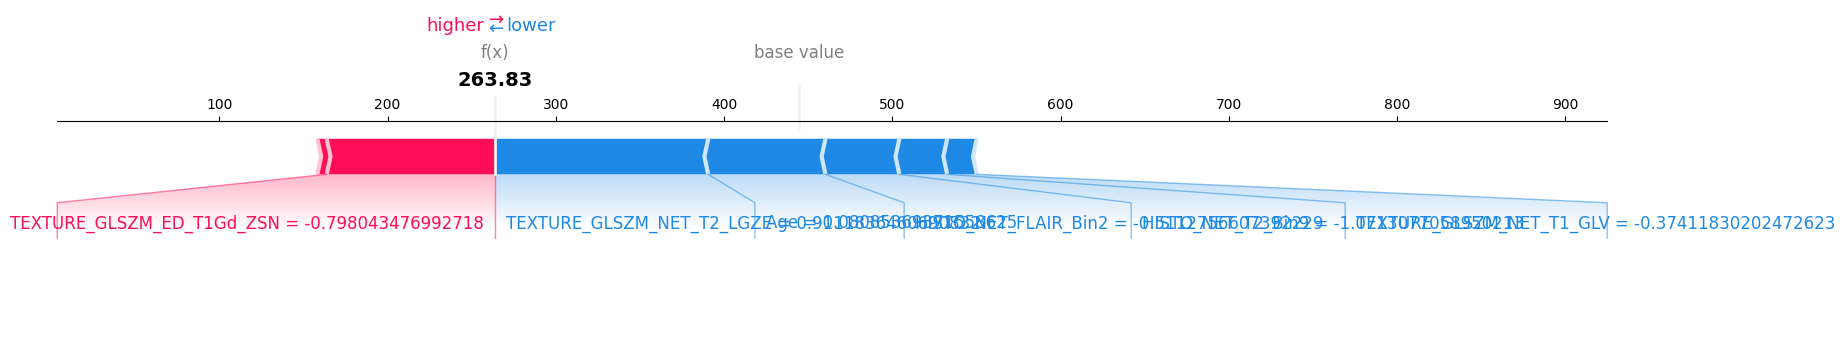

In [20]:
shap.plots.force(shap_values[1],matplotlib=True)

### Stacked Force Plot

In [49]:
shap.plots.force(shap_values[0:76], matplotlib=True)

NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!

## Mean SHAP plot

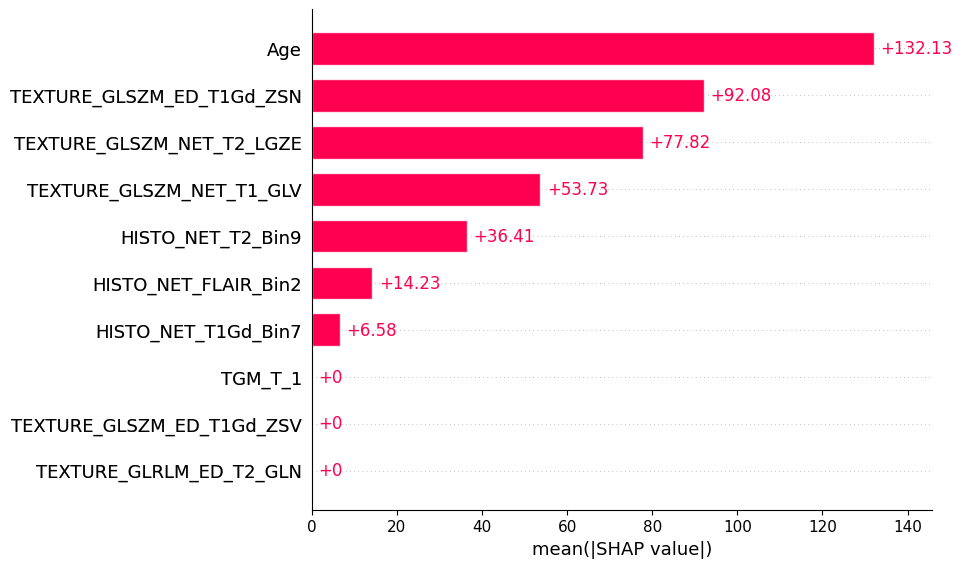

In [21]:
shap.plots.bar(shap_values)

Here we can see that AGE is the most deciding factor. But in the previous individual plots texture features were prominent. Also there are 3 features that doesn't contribute at all.

## Beeswarm (Important)

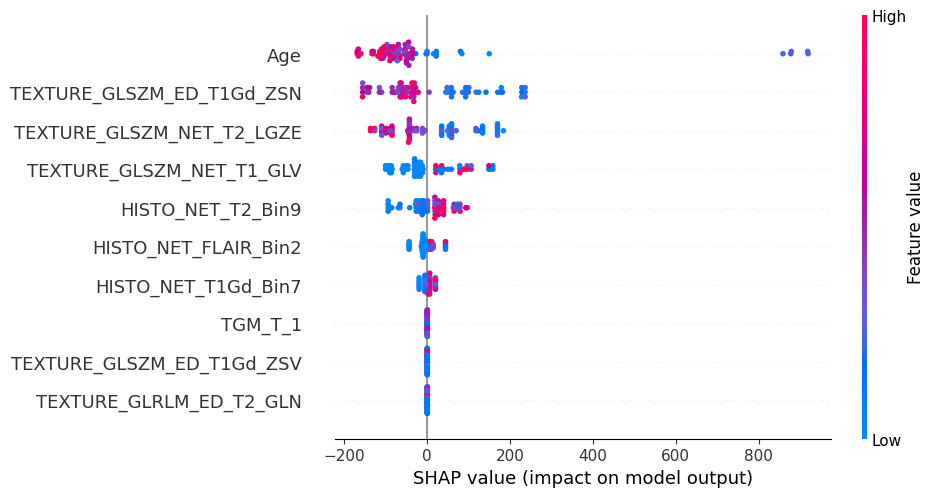

In [22]:
shap.plots.beeswarm(shap_values)

Check this with the dataset

- There are some young pateints with high rate of survival. (4, 55, 43...) --> These samples are the ones that contributes to AGE being prominent. (Age values are normalized)

- It is visible that there is an inverse relationship between 1st 3 texture based features and the 3 histogram based features. (Have to check with dependancy plots)

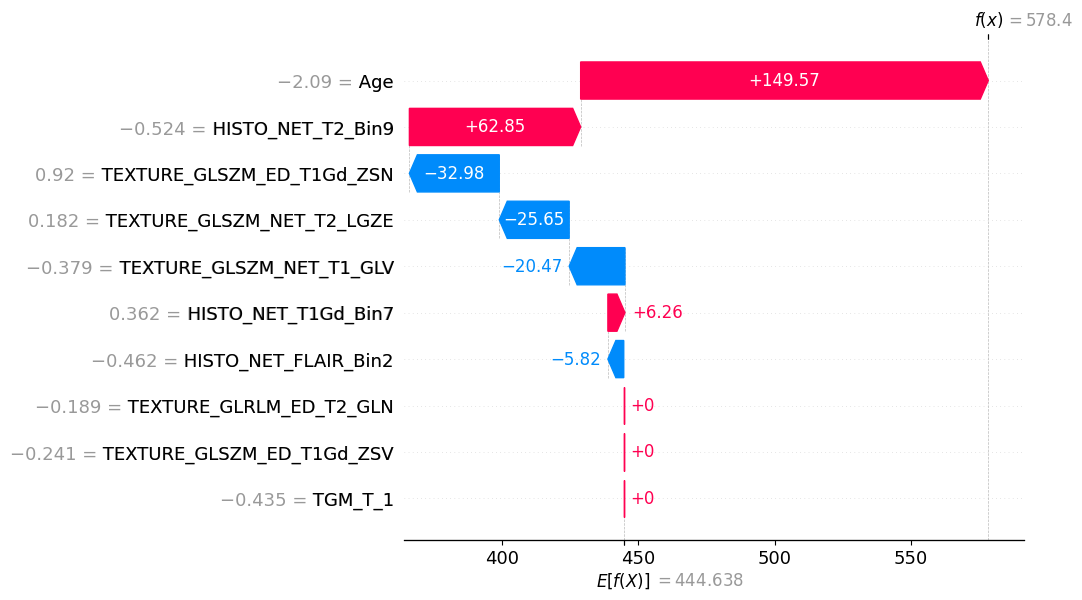

In [23]:
shap.plots.waterfall(shap_values[3])

## Dependence plots

Selected 10 features: Index(['HISTO_NET_T1Gd_Bin7', 'HISTO_NET_T2_Bin9', 'HISTO_NET_FLAIR_Bin2', 'TEXTURE_GLRLM_ED_T2_GLN', 'TEXTURE_GLSZM_ED_T1Gd_ZSN', 'TEXTURE_GLSZM_ED_T1Gd_ZSV', 'TEXTURE_GLSZM_NET_T1_GLV', 'TEXTURE_GLSZM_NET_T2_LGZE', 'TGM_T_1', 'Age'])

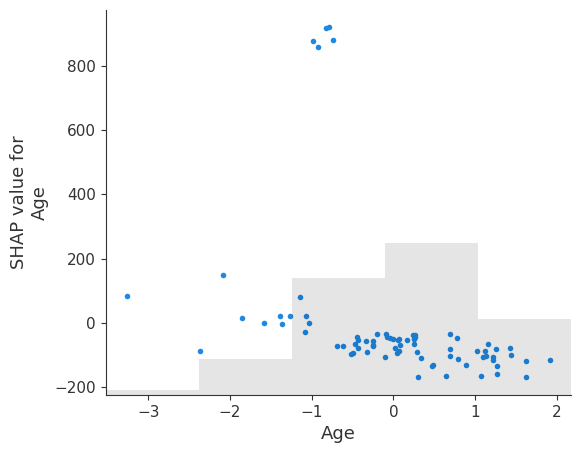

In [24]:
# Age
shap.plots.scatter(shap_values[:,"Age"])

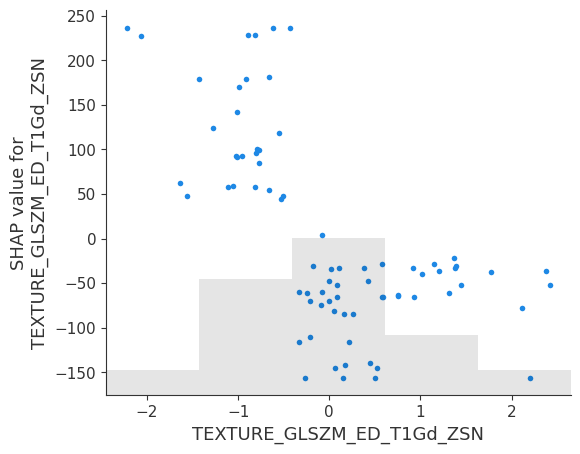

In [25]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLSZM_ED_T1Gd_ZSN"])

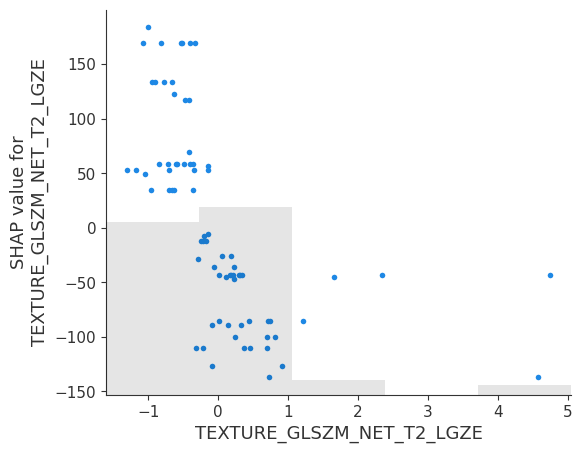

In [26]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLSZM_NET_T2_LGZE"])

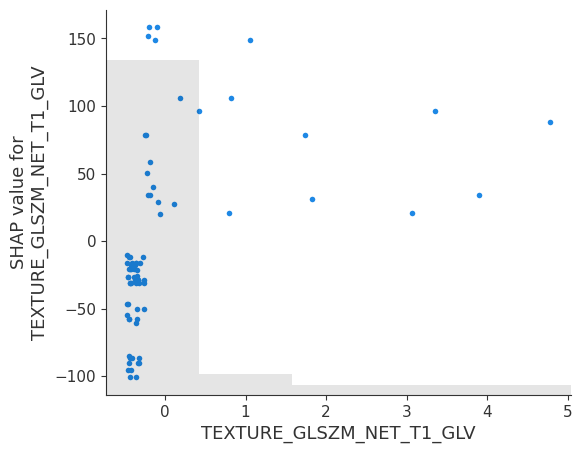

In [27]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLSZM_NET_T1_GLV"])

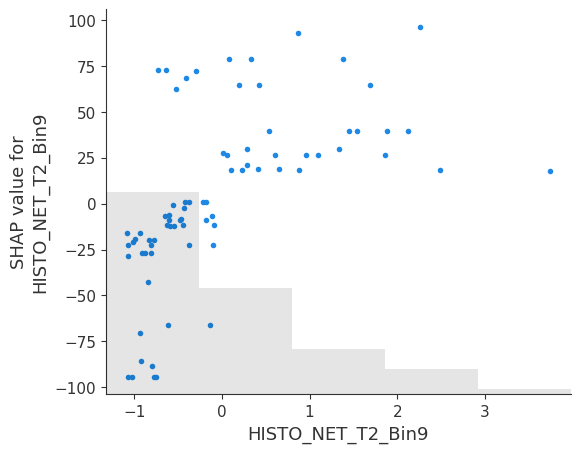

In [28]:
shap.plots.scatter(shap_values[:,"HISTO_NET_T2_Bin9"])

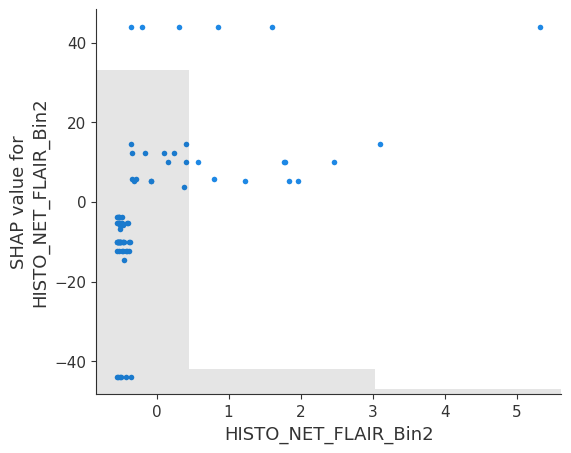

In [29]:
shap.plots.scatter(shap_values[:,"HISTO_NET_FLAIR_Bin2"])

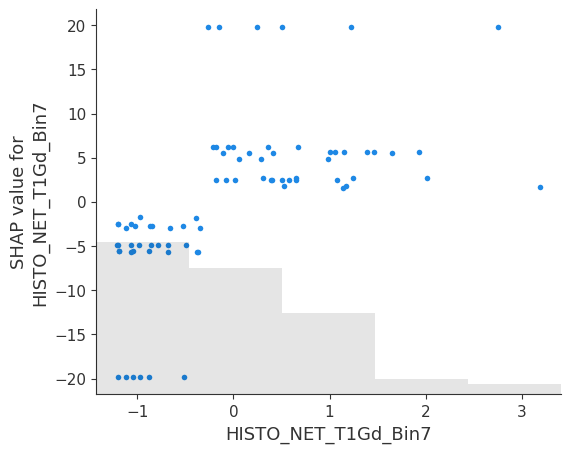

In [30]:
shap.plots.scatter(shap_values[:,"HISTO_NET_T1Gd_Bin7"])

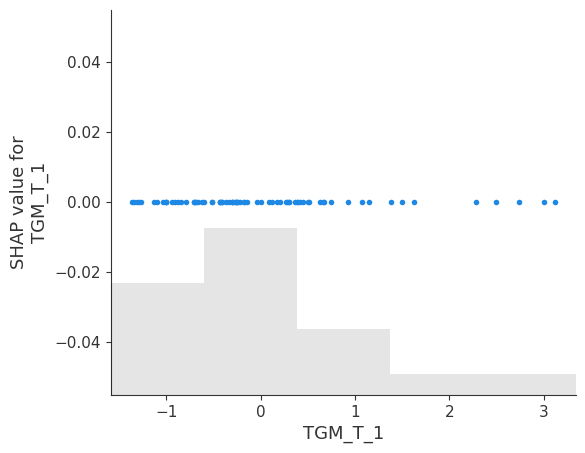

In [31]:
shap.plots.scatter(shap_values[:,"TGM_T_1"])

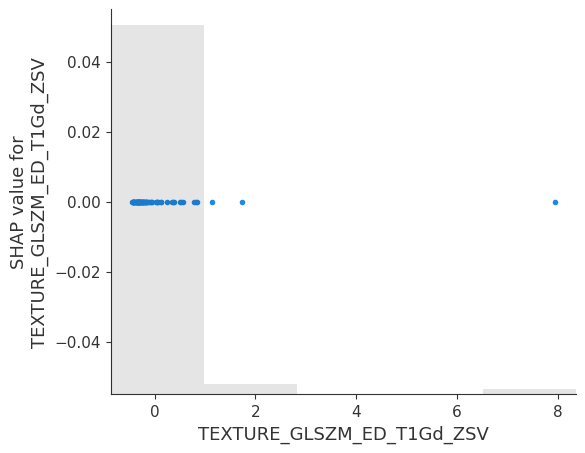

In [32]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLSZM_ED_T1Gd_ZSV"])

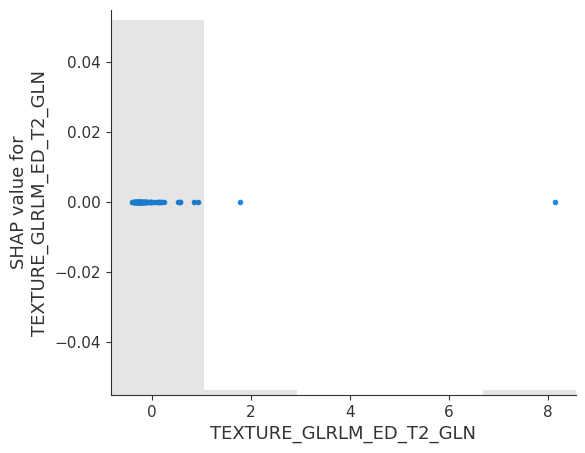

In [33]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLRLM_ED_T2_GLN"])

Last 3 features doesn't contribute at all to the model predictions.

### Interaction Dependance Plots

#### Check with Age

##### 1

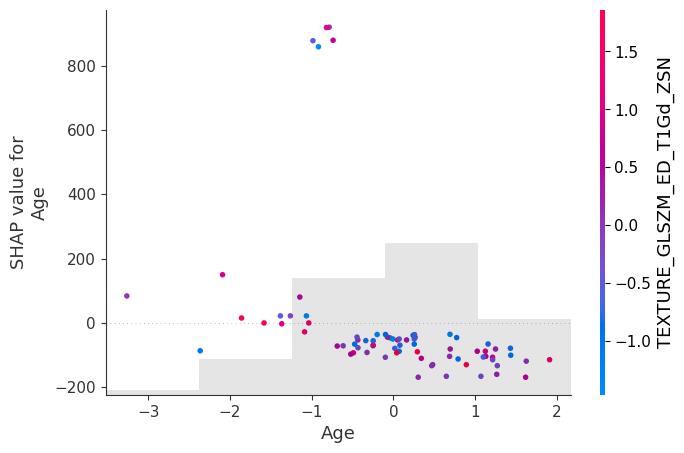

In [34]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"TEXTURE_GLSZM_ED_T1Gd_ZSN"])

It seems that, if Age is higher it tends to decrease the SHAP values down, hence the Survival days is decreased.

But generally high T1 values tend to decrease the SHAP values even more.

**However, some pateints with very high SHAP for Age (that means their SD prediction's prominent feature is Age), tend to have higher T1 values.**

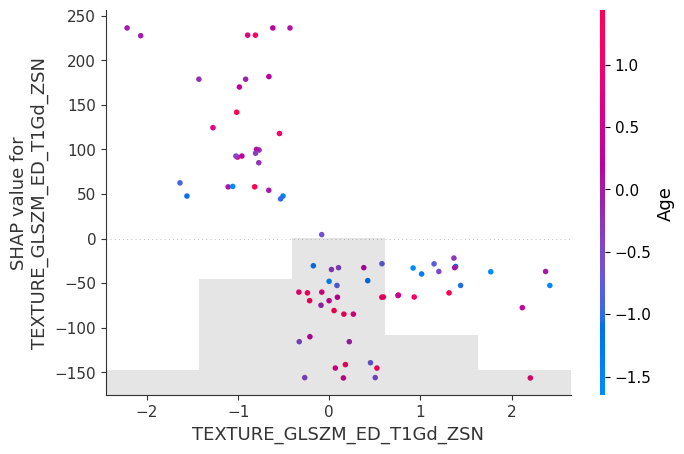

In [35]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLSZM_ED_T1Gd_ZSN"], color=shap_values[:,"Age"])

##### 2

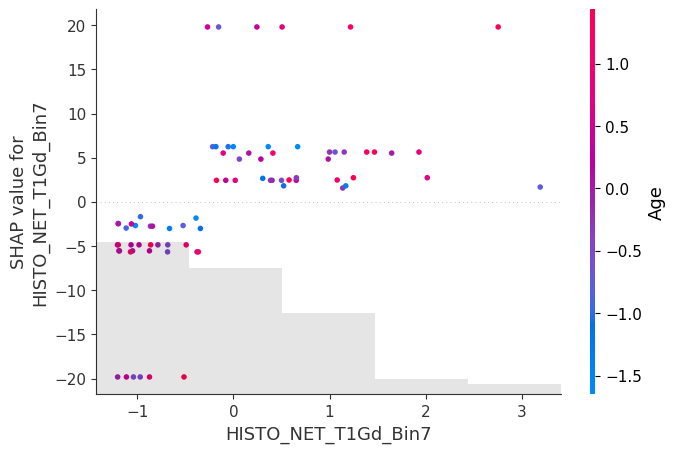

In [36]:
shap.plots.scatter(shap_values[:,"HISTO_NET_T1Gd_Bin7"], color=shap_values[:,"Age"])

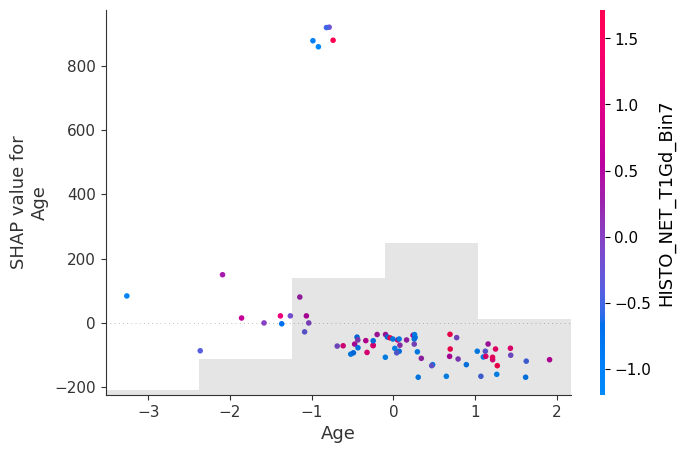

In [37]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"HISTO_NET_T1Gd_Bin7"])

##### 3

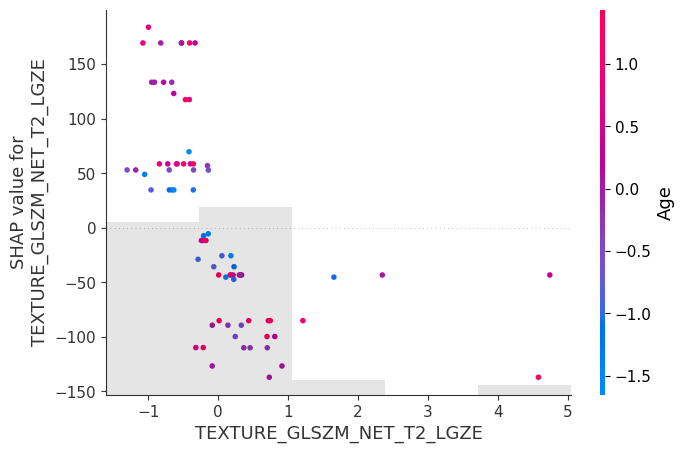

In [38]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLSZM_NET_T2_LGZE"], color=shap_values[:,"Age"])

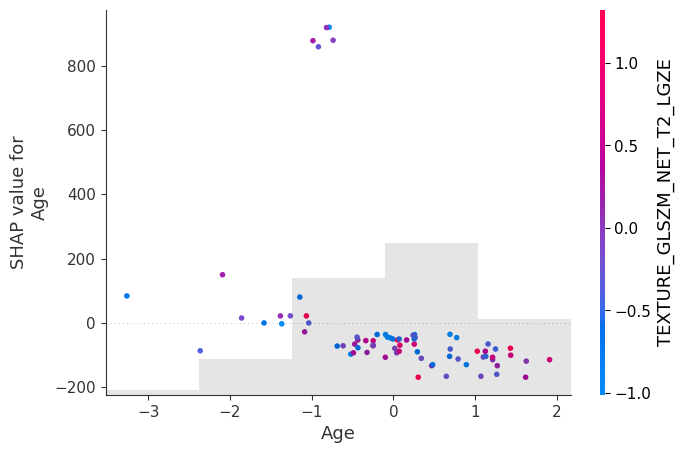

In [39]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"TEXTURE_GLSZM_NET_T2_LGZE"])

# Analysing Interactions with SHAP (Decision Tree - 10 features)

In [47]:
explainer = shap.TreeExplainer(model_shap,feature_names=valid_columns)
shap_interaction = explainer.shap_interaction_values(selected_values)
shap_interaction.shape

(76, 10, 10)

It's 76 10x10 matices. These 10x10 matrices are contribution matrices.

In [48]:
# SHAP interaction value for arbitory sample
pd.DataFrame(shap_interaction[0], index = valid_columns, columns = valid_columns)

,HISTO_NET_T1Gd_Bin7,HISTO_NET_T2_Bin9,HISTO_NET_FLAIR_Bin2,TEXTURE_GLRLM_ED_T2_GLN,TEXTURE_GLSZM_ED_T1Gd_ZSN,TEXTURE_GLSZM_ED_T1Gd_ZSV,TEXTURE_GLSZM_NET_T1_GLV,TEXTURE_GLSZM_NET_T2_LGZE,TGM_T_1,Age
HISTO_NET_T1Gd_Bin7,5.736111,1.173547,0.000000,0.0,-2.259806,0.0,-2.259806,0.000000,0.0,0.353311
HISTO_NET_T2_Bin9,1.173547,-41.669049,0.000000,0.0,7.636779,0.0,7.636779,0.000000,0.0,5.598547
HISTO_NET_FLAIR_Bin2,0.000000,0.000000,9.026843,0.0,18.282091,0.0,0.000000,11.408083,0.0,5.212000
TEXTURE_GLRLM_ED_T2_GLN,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
TEXTURE_GLSZM_ED_T1Gd_ZSN,-2.259806,7.636779,18.282091,0.0,112.611109,0.0,-29.915251,-19.304242,0.0,8.715335
TEXTURE_GLSZM_ED_T1Gd_ZSV,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
TEXTURE_GLSZM_NET_T1_GLV,-2.259806,7.636779,0.000000,0.0,-29.915251,0.0,63.947011,-9.434497,0.0,0.833283
TEXTURE_GLSZM_NET_T2_LGZE,0.000000,0.000000,11.408083,0.0,-19.304242,0.0,-9.434497,-79.378558,0.0,-13.327211
TGM_T_1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
Age,0.353311,5.598547,5.212000,0.0,8.715335,0.0,0.833283,-13.327211,0.0,-62.775698


Main effects are on the diagonal. The interaction effects are halved. This df + mean prediction == prediction

## Absolute Mean Plot

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'HISTO_NET_T1Gd_Bin7'),
  Text(0, 1.5, 'HISTO_NET_T2_Bin9'),
  Text(0, 2.5, 'HISTO_NET_FLAIR_Bin2'),
  Text(0, 3.5, 'TEXTURE_GLRLM_ED_T2_GLN'),
  Text(0, 4.5, 'TEXTURE_GLSZM_ED_T1Gd_ZSN'),
  Text(0, 5.5, 'TEXTURE_GLSZM_ED_T1Gd_ZSV'),
  Text(0, 6.5, 'TEXTURE_GLSZM_NET_T1_GLV'),
  Text(0, 7.5, 'TEXTURE_GLSZM_NET_T2_LGZE'),
  Text(0, 8.5, 'TGM_T_1'),
  Text(0, 9.5, 'Age')])

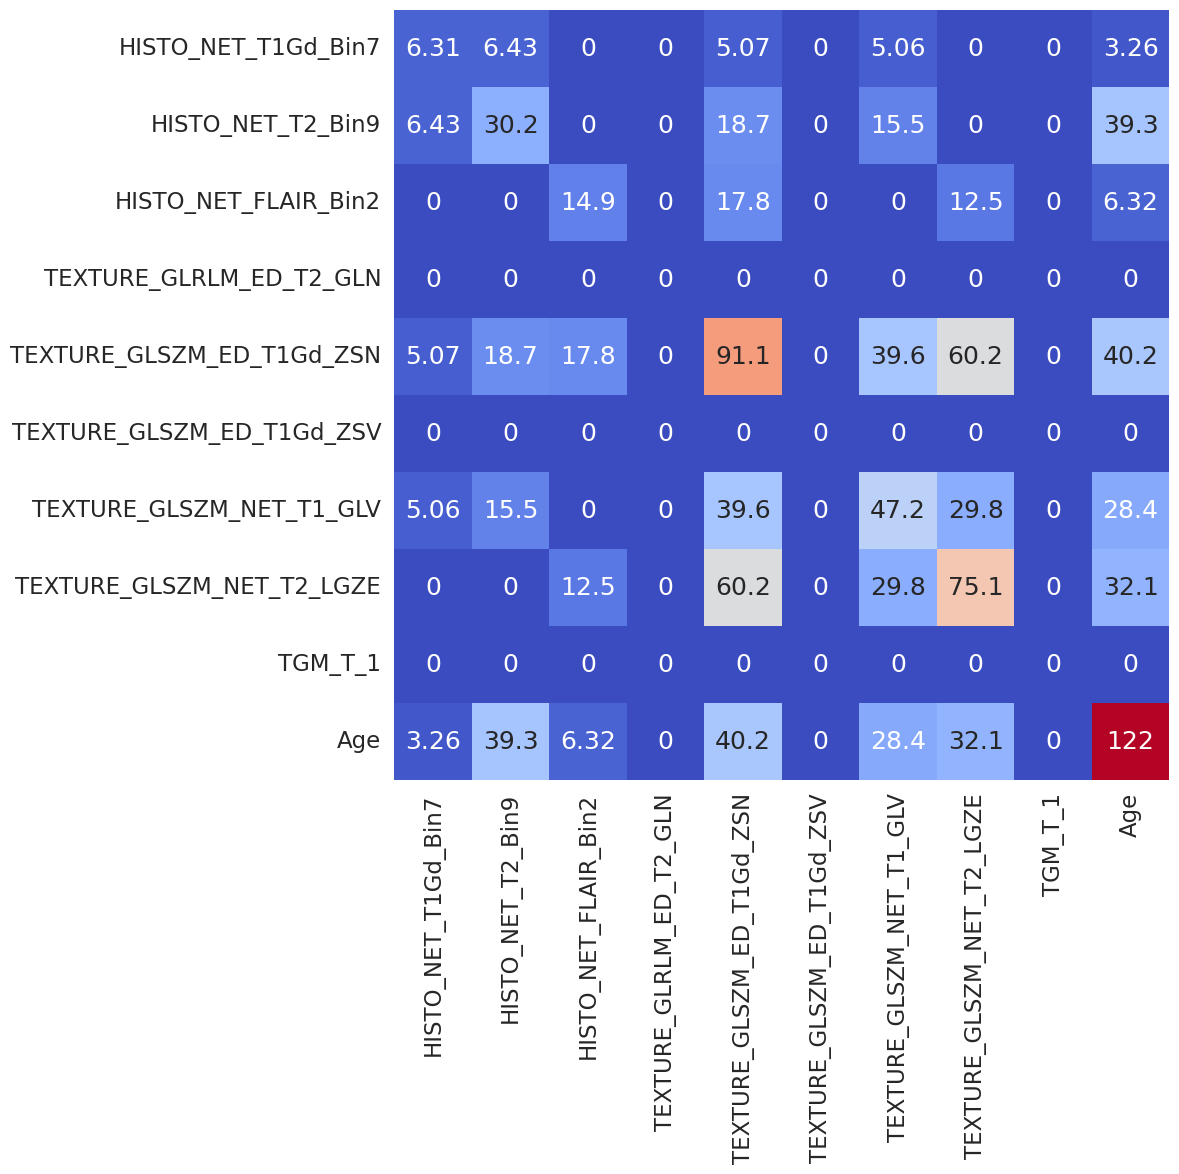

In [49]:
# Get the absolute means of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df_mean_shap = pd.DataFrame(mean_shap, index = valid_columns, columns = valid_columns)

# since interaction effects are halved
df_mean_shap.where(df_mean_shap.values == np.diagonal(df_mean_shap), df_mean_shap.values*2, inplace = True)

#display
plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.set(font_scale = 1.5)
sns.heatmap(df_mean_shap, cmap='coolwarm', annot=True, fmt='.3g', cbar=False)
plt.yticks(rotation=0)

Significant Main Effects are 1, 4, 6, 7, 9

Can see some several different interactions above. --> Check with dependance plots <br>
(1,4) - 18.7<br>
(1,6) - 15.5<br>
(1,9) - 39.3<br>
(2,4) - 17.8<br>
(4,6) - 39.6<br>
(4,7) - 60.2<br>
(4,9) - 40.2<br>
(6,7) - 29.8<br>
(6,9) - 28.4<br>
(7,9) - 32.1<br>


## SHAP interaction beeswarm plot

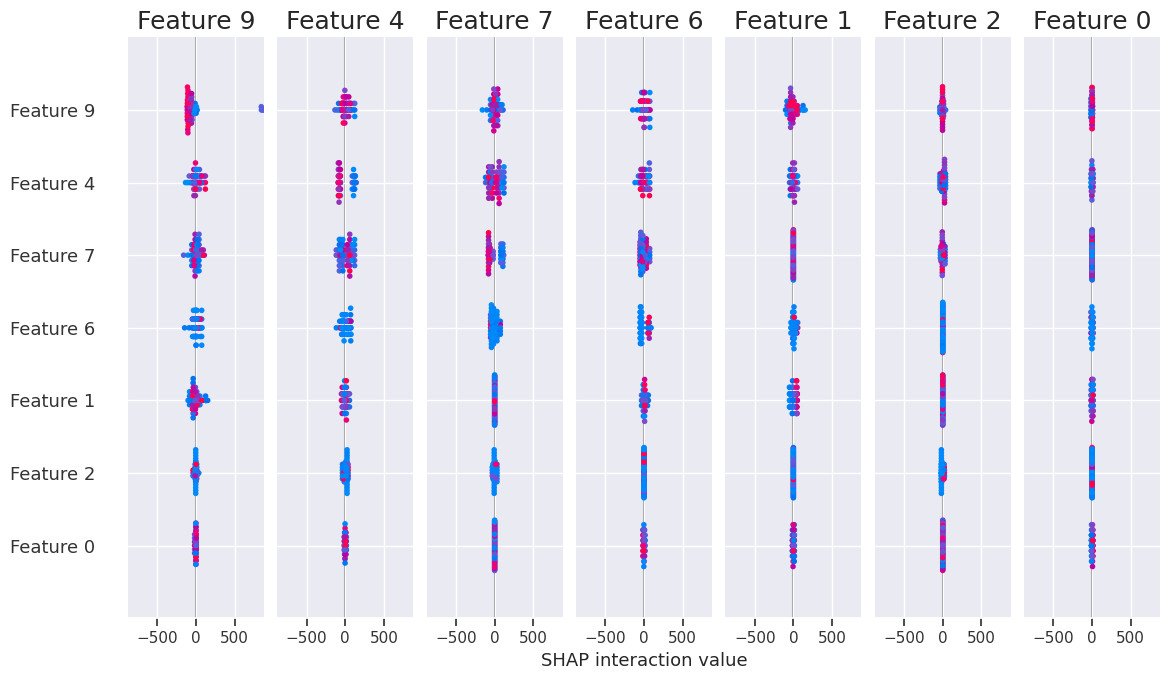

In [50]:
shap.summary_plot(shap_interaction, selected_values)

(Error popped in above cell when using feature names)

Above plot depicts that, main effects 9, 4, 7 are negative.

Meanwhile, main effects 6, 1 & 2 are positive.

## Dependace plots

**These plots are only for the interaction effects. The relationships should be considered in light of the main effects of bothe features**

**If main effects and interaction effects both work in the same direction, the predictions also work in the same direction. But if they work in the opposite direction then there is no conclusion to the prediction ?**

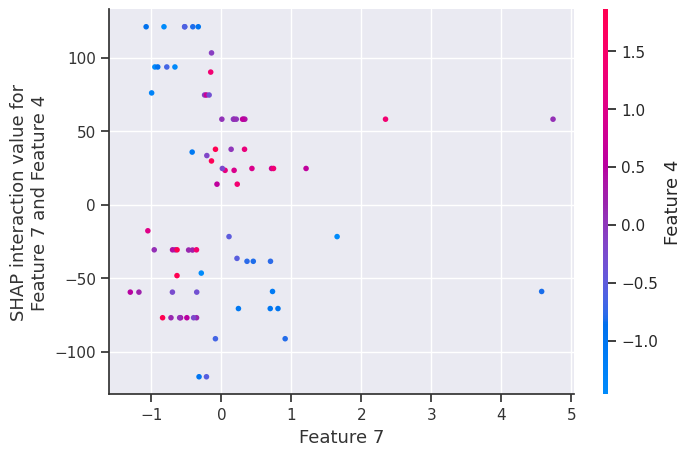

In [51]:
shap.dependence_plot(
                    ("Feature 7","Feature 4"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

A clear interaction between these 2 features. (TEXTURE_GLSZM_NET_T2_LGZE, TEXTURE_GLSZM_ED_T1Gd_ZSN)

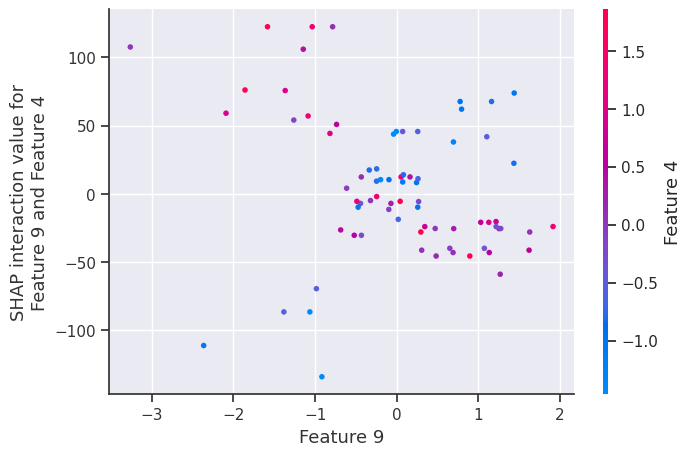

In [52]:
shap.dependence_plot(
                    ("Feature 9","Feature 4"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(Age, TEXTURE_GLSZM_ED_T1Gd_ZSN)

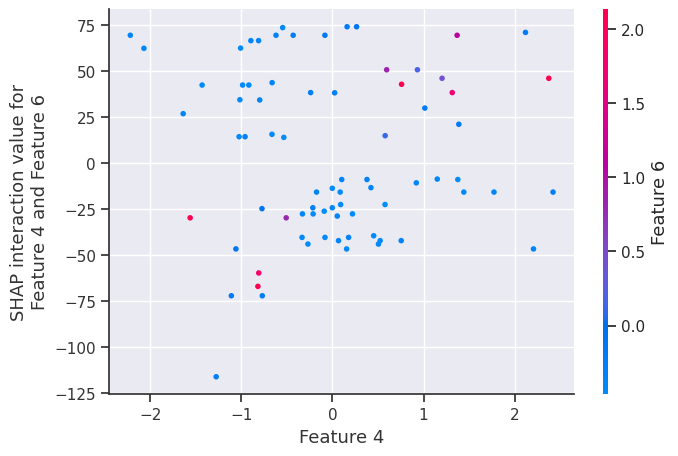

In [53]:
shap.dependence_plot(
                    ("Feature 4","Feature 6"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(TEXTURE_GLSZM_ED_T1Gd_ZSN, TEXTURE_GLSZM_NET_T1_GLV)

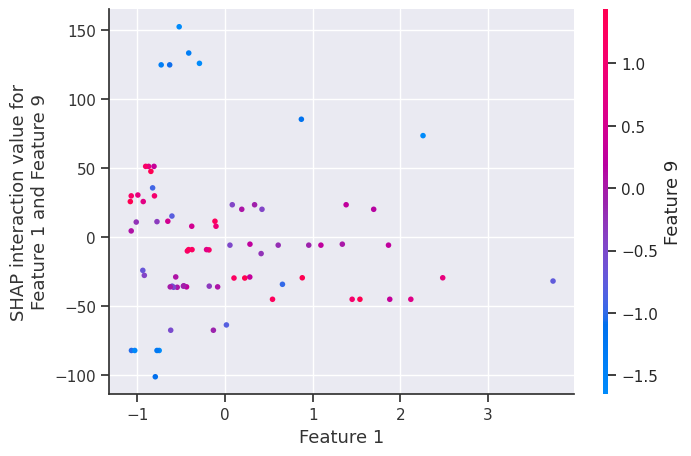

In [55]:
shap.dependence_plot(
                    ("Feature 1","Feature 9"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(HISTO_NET_T2_Bin9, Age)

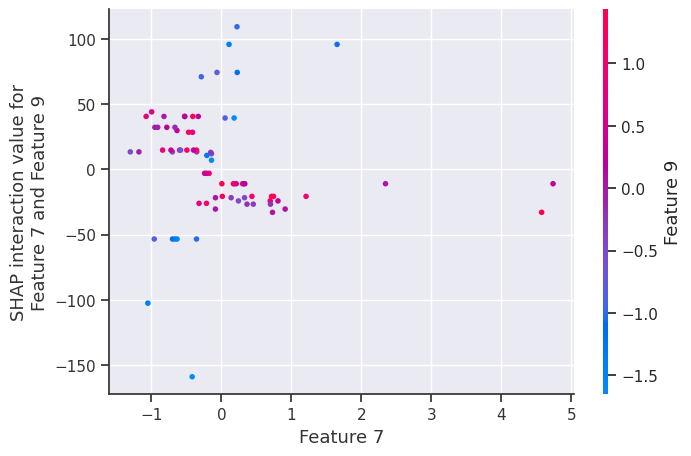

In [56]:
shap.dependence_plot(
                    ("Feature 7","Feature 9"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(TEXTURE_GLSZM_NET_T2_LGZE, Age)

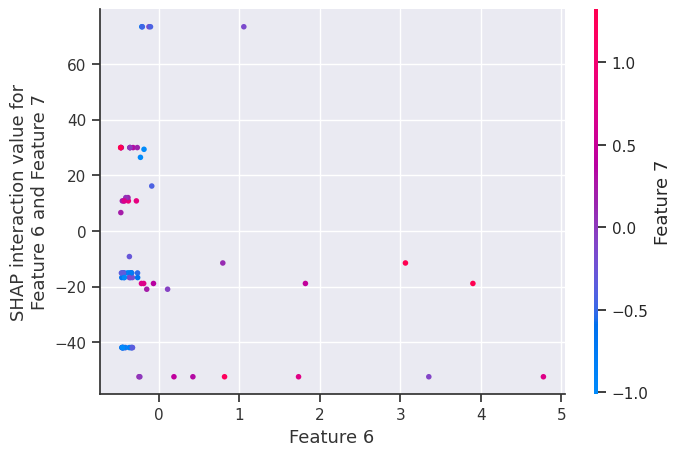

In [57]:
shap.dependence_plot(
                    ("Feature 6","Feature 7"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(TEXTURE_GLSZM_NET_T1_GLV,TEXTURE_GLSZM_NET_T2_LGZE)

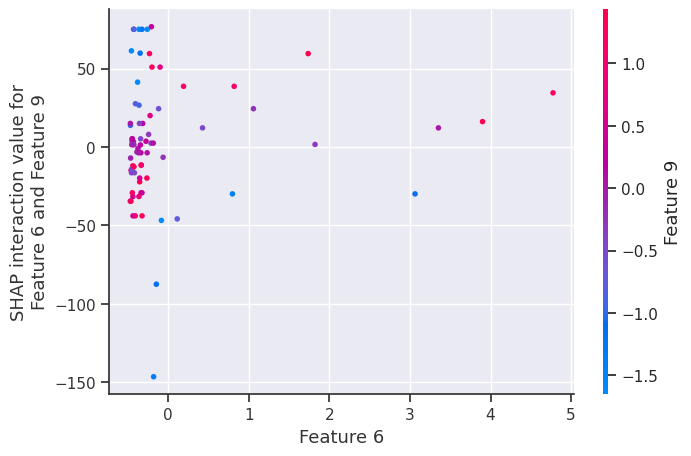

In [58]:
shap.dependence_plot(
                    ("Feature 6","Feature 9"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(TEXTURE_GLSZM_NET_T1_GLV, Age)

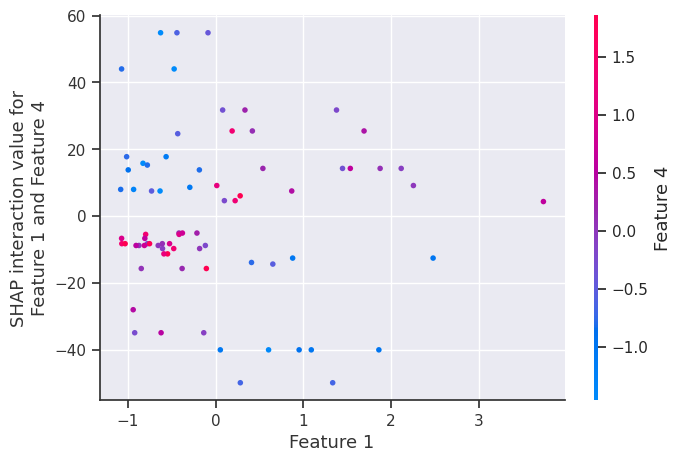

In [59]:
shap.dependence_plot(
                    ("Feature 1","Feature 4"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(HISTO_NET_T2_Bin9, TEXTURE_GLSZM_ED_T1Gd_ZSN)

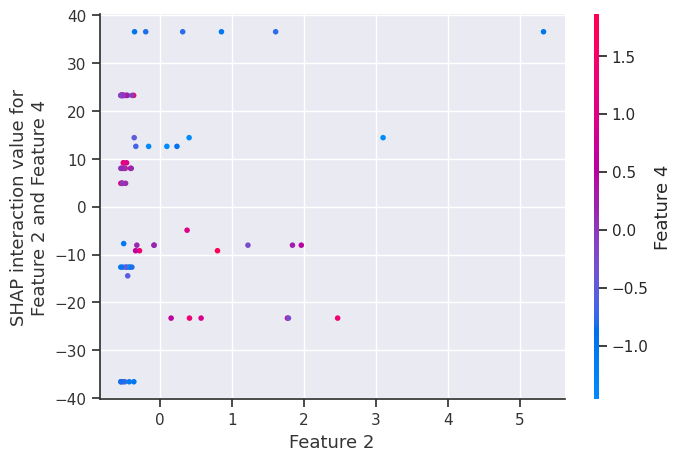

In [60]:
shap.dependence_plot(
                    ("Feature 2","Feature 4"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(HISTO_NET_FLAIR_Bin2, TEXTURE_GLSZM_ED_T1Gd_ZSN)

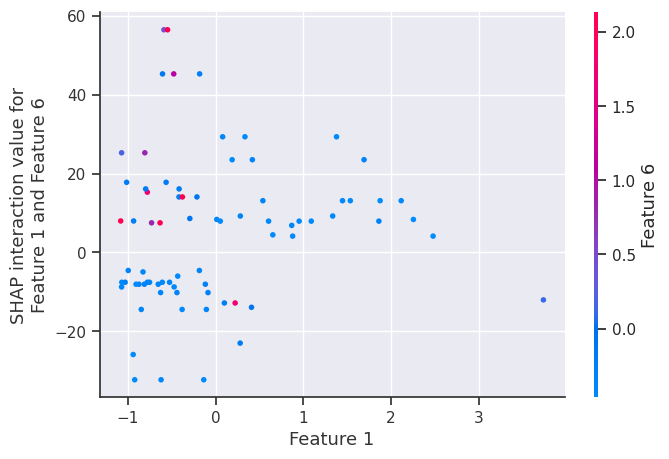

In [61]:
shap.dependence_plot(
                    ("Feature 1","Feature 6"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

(HISTO_NET_T2_Bin, TEXTURE_GLSZM_NET_T1_GLV)